In [2]:
# [1] SETUP AND FILE PATHS

# Install required libraries (only needs to run once)
# !pip install rasterio numpy matplotlib

# Import required libraries
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore') 

# --- Define File Paths ---
# NOTE: Assuming these files are in the same directory as this notebook
dem_path = 'pasig_DEM_clipped.tif'
slope_path = 'pasig_slope.tif'

# Define the output file path for the Cost Surface
cost_surface_path = 'pasig_cost_surface.tif' 

print("✅ Libraries imported successfully!")
print("📁 File paths set.")

✅ Libraries imported successfully!
📁 File paths set.


In [3]:
# [2] LOAD DATA AND METADATA

print("Loading data...")

# Load DEM data and metadata
with rasterio.open(dem_path) as src:
    dem_raw = src.read(1)
    dem_meta = src.meta.copy()  # Save the blueprint for later export
    NODATA = src.nodata         # Save the NoData value
    print(f"✅ DEM loaded: {src.shape}")

# Load Slope data
with rasterio.open(slope_path) as src:
    slope_raw = src.read(1)
    print(f"✅ Slope loaded: {src.shape}")
    
print(f"Original DEM NoData value is: {NODATA}")

Loading data...
✅ DEM loaded: (61, 53)
✅ Slope loaded: (61, 53)
Original DEM NoData value is: -32767.0


In [4]:
# [3] CLEAN DATA (Handle NoData values)

print("Cleaning data...")

# 1. Clean the DEM array: Replace the original NoData value with NaN
# Use a general threshold of -1000 since exact NODATA value can vary 
dem_clean = np.where(dem_raw < -1000, np.nan, dem_raw)

# 2. Clean the Slope array: Replace negative or zero values with NaN
slope_clean = np.where(slope_raw <= 0, np.nan, slope_raw)

# Check the cleaned data range
print(f"Cleaned DEM range: {np.nanmin(dem_clean):.1f} to {np.nanmax(dem_clean):.1f}")
print(f"Cleaned Slope range: {np.nanmin(slope_clean):.1f} to {np.nanmax(slope_clean):.1f}")
print("✅ Data cleaning complete.")

Cleaning data...
Cleaned DEM range: -1.0 to 20.0
Cleaned Slope range: 89.9 to 90.0
✅ Data cleaning complete.


In [5]:
# [4] CALCULATE OPTIMAL PATH COST SURFACE (MCDM)

print("Calculating Cost Surface...")

# --- 4a. Normalize and Invert the Data ---

# Normalize both arrays (Scale to 0-1)
norm_dem = (dem_clean - np.nanmin(dem_clean)) / (np.nanmax(dem_clean) - np.nanmin(dem_clean))
norm_slope = (slope_clean - np.nanmin(slope_clean)) / (np.nanmax(slope_clean) - np.nanmin(slope_clean))

# Calculate Cost Logic:
# 1. Slope Cost: High Slope = High Cost (Direct use)
slope_cost_array = norm_slope

# 2. DEM Cost: Low Elevation = High Cost (Inverse logic: 1 - normalized_value)
dem_cost_array = 1 - norm_dem

# --- 4b. Weighted Overlay ---

W_SLOPE = 0.70  # Primary factor: Vehicle stability/safety
W_DEM = 0.30    # Secondary factor: Avoiding low-lying/flood zones

# Final Cost Surface Calculation (The AI-Ready Input)
cost_surface_array = (slope_cost_array * W_SLOPE) + (dem_cost_array * W_DEM)

print(f"✅ Cost Surface array calculated. Range: {np.nanmin(cost_surface_array):.3f} to {np.nanmax(cost_surface_array):.3f}")

Calculating Cost Surface...
✅ Cost Surface array calculated. Range: 0.100 to 0.949


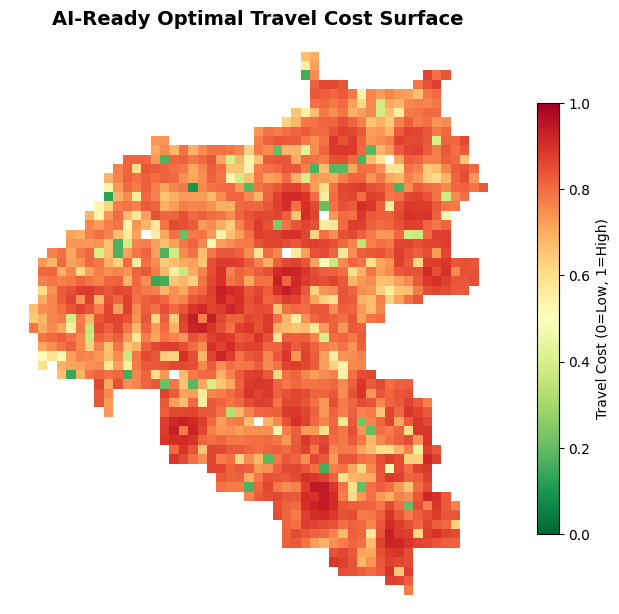

✅ Visualization complete.
--------------------------------------------------
🎯 FINAL DELIVERABLE EXPORTED
File: pasig_cost_surface.tif
Ready to switch to QGIS for final path-finding visualization!


In [6]:
# [5] EXPORT AND VISUALIZE COST SURFACE

# --- 5a. Visualization ---
fig, ax = plt.subplots(figsize=(8, 8))
# Use a reversed color map to show High Cost (1) as Red
im = ax.imshow(cost_surface_array, cmap='RdYlGn_r', vmin=0, vmax=1) 
ax.set_title('AI-Ready Optimal Travel Cost Surface', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax, label='Travel Cost (0=Low, 1=High)', shrink=0.7)
ax.axis('off')
plt.show()
print("✅ Visualization complete.")


# --- 5b. Export the Final GeoTIFF ---
NEW_NODATA = -9999.0

# Update the metadata for the new float raster
output_meta = dem_meta.copy()
output_meta.update({
    'dtype': 'float32',
    'nodata': NEW_NODATA
})

# Replace NumPy NaNs with the new raster NoData value for export
cost_surface_export = np.nan_to_num(cost_surface_array, nan=NEW_NODATA)

# Export the final GeoTIFF
with rasterio.open(cost_surface_path, 'w', **output_meta) as dst:
    # Ensure the dimensions match before writing
    if cost_surface_export.shape == dem_raw.shape:
        dst.write(cost_surface_export.astype(rasterio.float32), 1)
    
print("-" * 50)
print("🎯 FINAL DELIVERABLE EXPORTED")
print(f"File: {cost_surface_path}")
print("Ready to switch to QGIS for final path-finding visualization!")